In [2]:
import pandas as pd
import numpy as np
from IPython.display import display , HTML
import re
from time import sleep, time
import datetime
import matplotlib.pyplot as plt

states = {
'Goa' : [5, 4] 
,'UK' : [28, 7]
,'Manipur' : [14, 6]
,'Punjab' : [19, 12]
,'UP' : [24, 41]
}

ans = {}
start_scan = time()
for sname,snum_pages in states.items():
    start_state = time()
    ans[sname] = []
    snum = snum_pages[0]
    pages = snum_pages[1]
    for pg in range(1, pages+1):
        # if pg>5: break
        url = f"https://results.eci.gov.in/ResultAcGenMar2022/statewiseS{snum:02d}{pg}.htm"
        tbls = pd.read_html(url)
        tbls = [ x for x in tbls if x.shape[1] > 3 ]
        df = pd.read_html(url)[-2]
        # display( f"{sname}-{pg}/{pages}" , url,  [ x.shape for x in tbls  ] )
        for t in tbls[-1:]: 
            # t = t[  [re.match(r"^\d+$", s ) for s in t.iloc[:,1].str] ]
            filt =  [ bool(re.match("^\d+$",str(x)))  for x in t.iloc[:,1]  ]
            t = t[filt]
            t = t.applymap(lambda x: re.sub("iParty Wise.*", "", x) if 'iParty' in str(x) else x)
            # drop last three columns
            t = t.iloc[:,:-3]
            columns = ['Constituency', 'zcnum', 'Leading Candidate', 'Leading Party', 'Trailing Candidate', 'Trailing Party' , 'Margin', 'Status']
            t.columns = columns
            t['State'] = sname
            t = t[['State'] + columns]
            ans[sname].append(t)
            # print (f"{sname} -{pg}/{pages} - {t.shape} - {len(ans[sname])} - {int(time()-start_state)}s - {int(time()-start_scan)}s")


In [3]:
chunav = pd.concat([ pd.concat(dfs, axis=0) for sname, dfs in ans.items()], axis=0)
chunav.Margin = chunav.Margin.apply(lambda x: int(x))
chunav['Leading Party'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Leading Party'], axis=1)
chunav['Trailing Party'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Trailing Party'], axis=1)
chunav['Leading Candidate'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Leading Candidate'], axis=1)
chunav['Trailing Candidate'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Trailing Candidate'], axis=1)
chunav.to_pickle("./chunav-early-2022.pickle")
winners = chunav['Leading Party'].value_counts().keys()
loosers = chunav['Trailing Party'].value_counts().keys()
ts = datetime.datetime.now().strftime("%b-%d-%Y %H:%M")
display(HTML(f'''
<h1> Chunav Early 2022 </h1> <small>  refreshed {ts} from <a href="https://results.eci.gov.in">eci.gov.in</a>  </small> <hr>
'''))

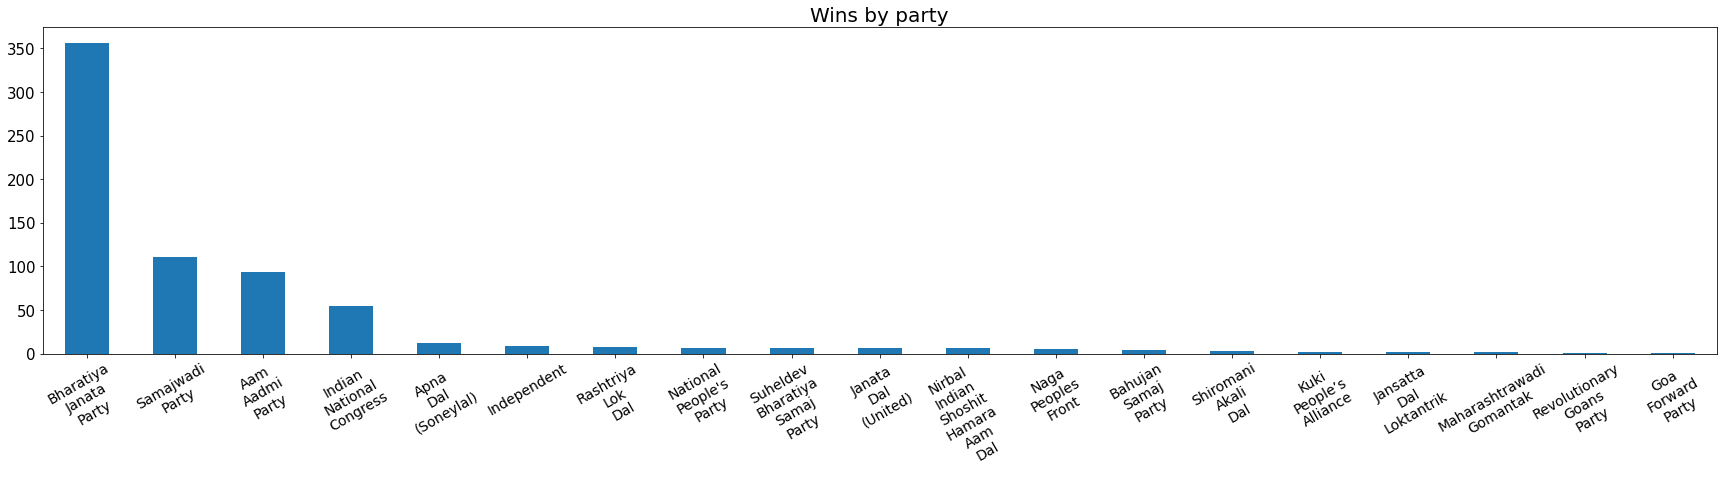

In [4]:
ax = chunav['Leading Party'].value_counts().sort_values(ascending=False).plot(kind='bar', rot=90 , figsize=(30,6), fontsize=15 )
ax.set_title("Wins by party", fontdict={'fontsize': 20})
ax.set_xticklabels( [ "\n".join(w.split()) for w in winners], fontsize=14, rotation=30);

In [5]:
chunav_cnt = pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=len).fillna(0)
chunav_cnt = chunav_cnt.reset_index()
h1 = chunav_cnt.style.format(precision=0).background_gradient(cmap='Blues').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .set_caption("<h2>Seats Won</h2>")\
    .hide(axis='index')\
    .to_html()
chunav_margin= pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=np.mean).fillna(0)
h2 = chunav_margin.style.format(precision=0).background_gradient(cmap='Oranges').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .set_caption("<h2>Mean Win Margin</h2>") \
    .hide(axis='index')\
    .to_html()

chunav_cnt = pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=len).fillna(0)
chunav_cnt = pd.DataFrame(chunav_cnt.sum(), columns=['']).T
h1t = chunav_cnt.style.format(precision=0).background_gradient(cmap='Blues').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .hide(axis='index')\
    .to_html()
chunav_margin= pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=np.mean).fillna(0)
chunav_margin = pd.DataFrame(chunav_margin.sum(), columns=['Party_Total']).T
h2t = chunav_margin.style.format(precision=0).background_gradient(cmap='Oranges').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .hide(axis='index')\
    .to_html()

display(HTML(f'''
<table >
    <tr><td>{h1}</td><td>{h2}</td></tr>
    <tr><td style="float:right"> {h1t}</td><td>{h2t}</td></tr>
</table>'''))


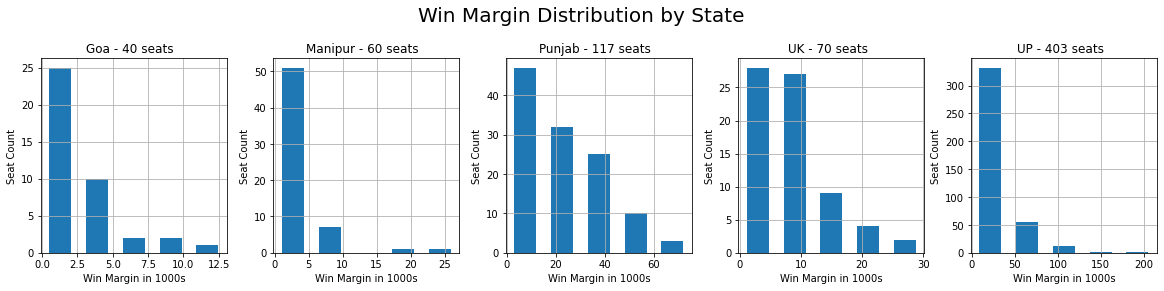

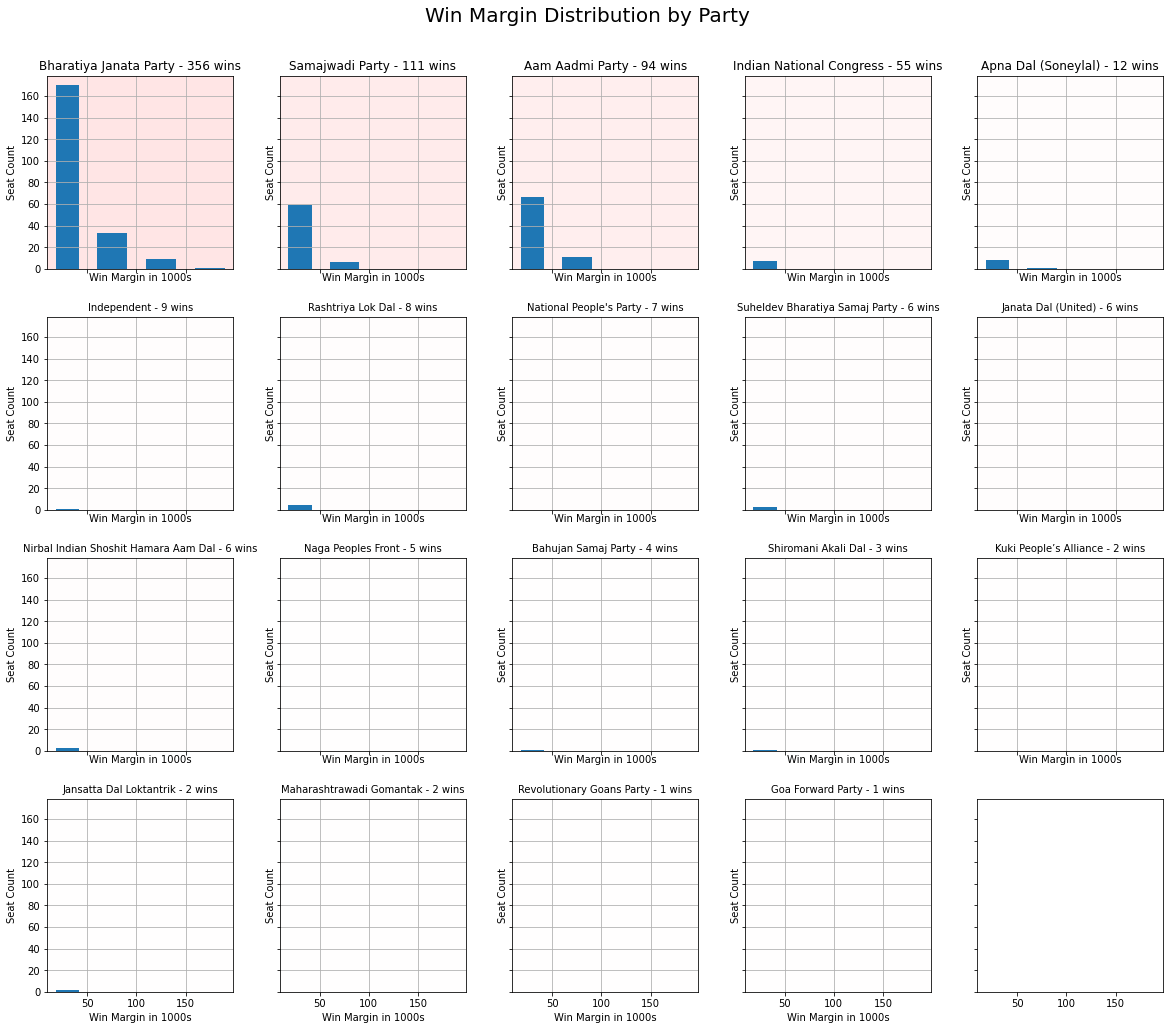

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(20,4), gridspec_kw={'hspace': .5 ,'wspace': 0.25})
axs = axs.flatten()
fig.suptitle('Win Margin Distribution by State', fontsize=20)
plt.subplots_adjust(top=.8)
ix = 0
for st, chunav_grp in chunav.groupby('State'):
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=5, rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Win Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    win = chunav_grp.shape[0]
    ax.set_title(f"{st} - {win} seats  ", fontsize=12)
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10);

fig, axs = plt.subplots(4, 5, figsize=(20,16), gridspec_kw={'hspace': .25 ,'wspace': 0.25 }, sharex= True, sharey=True)
axs = axs.flatten()
fig.suptitle('Win Margin Distribution by Party', fontsize=20)
plt.subplots_adjust(top=.92)
ix = 0
for st in winners:
    chunav_grp = chunav[chunav['Leading Party'] == st]
# for st, chunav_grp in chunav.groupby('Leading Party')
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=[10, 50, 100, 150, 200], rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Win Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    win = chunav_grp.shape[0]
    ax.set_title(f"{st} - {win} wins", fontsize=10 if win < 10 else 12)
    # if win > 10 :  ax.set_facecolor('yellow') 
    ax.set_facecolor((1,1-min(1,win/150),1-min(1,win/150),.1))
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10)


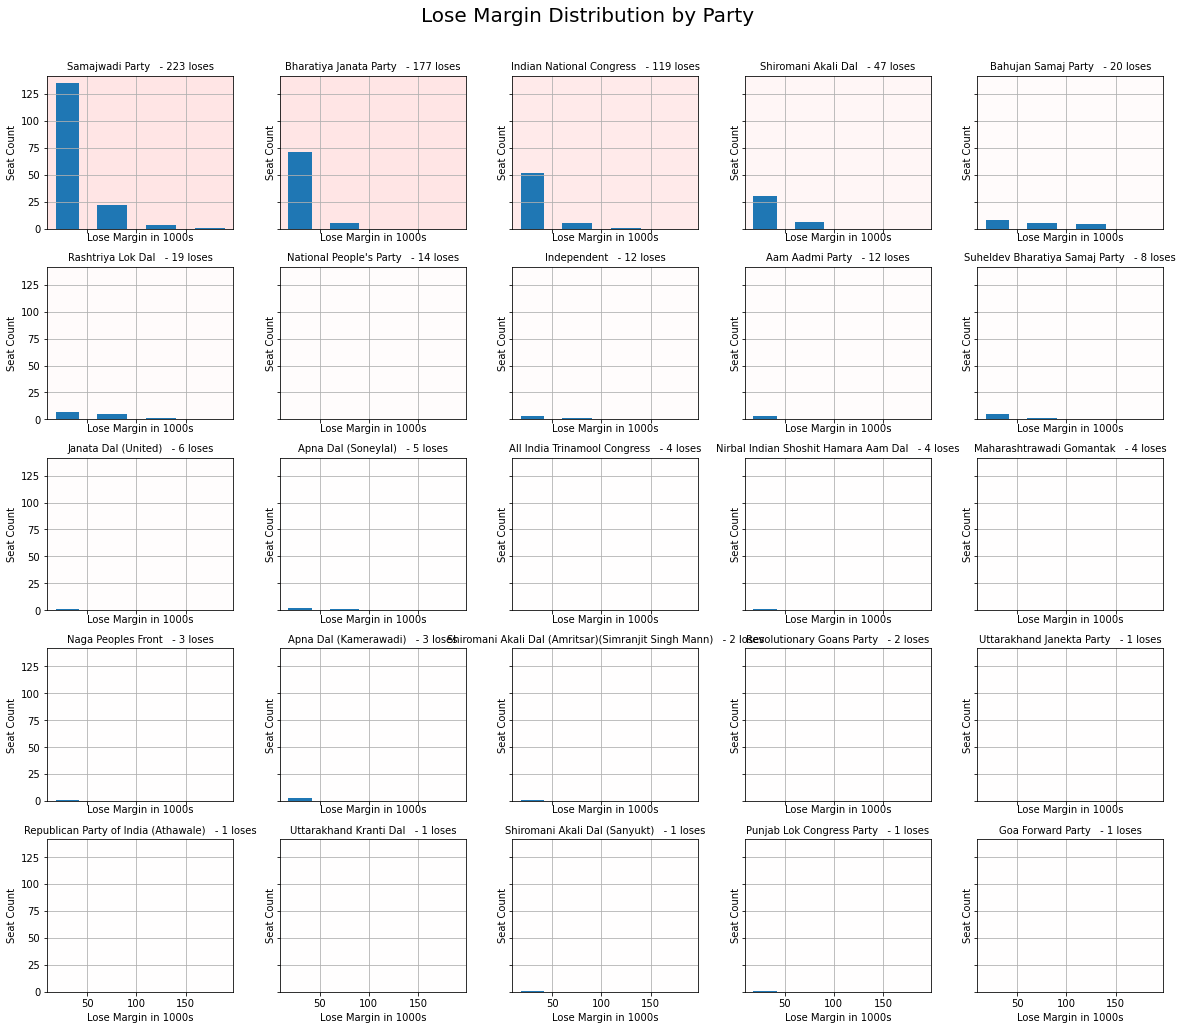

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(20,16), gridspec_kw={'hspace': .25 ,'wspace': 0.25 }, sharex= True, sharey=True)
axs = axs.flatten()
fig.suptitle('Lose Margin Distribution by Party', fontsize=20)
plt.subplots_adjust(top=.92)
ix = 0
for st in loosers:
    if ix > 25: break
    chunav_grp = chunav[chunav['Trailing Party'] == st]
# for st, chunav_grp in chunav.groupby('Leading Party')
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=[10, 50, 100, 150, 200], rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Lose Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    lose = chunav_grp.shape[0]
    ax.set_title(f"{st} - {lose} loses", fontsize=10 if win < 10 else 12)
    # if win > 10 :  ax.set_facecolor('yellow') 
    ax.set_facecolor((1,1-min(1,lose/150),1-min(1,lose/150),.1))
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10)

In [8]:
chunav = chunav.reset_index().drop(columns=['index'])
lc = chunav['Leading Candidate'].apply( lambda x : str(x).lower())
tc = chunav['Trailing Candidate'].apply( lambda x : str(x).lower())
cn = chunav['Constituency'].apply( lambda x : str(x).lower())

diggaj = pd.Series([
    'amarinder' , 'channi' , 'navjot' ,  'adityanath' , 'badal' , 
    'akhilesh yadav' , 'harish rawat' , 'pushkar' , 'azamgarh' , 'deoband' , 'rajbhar' , 
    'KESHAV PRASAD MAURYA', 'swami prasad' , 'dara' ,'dharam']).apply( lambda x : str(x).lower())

lc1 = lc.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )
tc1 = tc.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )
cn1 = cn.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )


chunav [ cn1 | lc1 | tc1 ].drop(columns=['zcnum']).sort_values('Margin', ascending=False).reset_index().drop(columns=['index']).style.set_caption("<h2>दिग्गज</h2>")


In [9]:
chunav.sort_values('Margin', ascending=False).reset_index().drop(columns=['index' , 'zcnum']).head(50).style.set_caption("<h2>Big Winners</h2>")

In [10]:
chunav.sort_values('Margin', ascending=True).reset_index().drop(columns=['index' , 'zcnum']).head(50).style.set_caption("<h2>Tight Winners</h2>")

In [11]:
chunav.drop(columns=['zcnum']).to_csv('./chunav-early-2022.csv')

In [132]:
try:
    contests = pd.read_pickle('./contests-early-2022.pickle')
except Exception as e:
    print(e)
    chunav['zstatecode'] = chunav.State.apply ( lambda x: states[x][0] )
    chunav[['State', 'Constituency' , 'zstatecode' , 'zcnum']]#.drop_duplicates().sort_values('zstatecode').drop(columns=['zstatecode']).style.set_caption("<h2>States</h2>")
    chunav2 = chunav.copy()
    chunav2.columns = [ re.sub("\s+", "", x) for x in chunav2.columns ]
    cntr = 0
    pcnt = 0
    ttl = chunav2.shape[0]
    acc =[]
    start = time()
    for r in chunav2.sort_values(['State', 'Constituency']).itertuples():
        # print(r.State, r.Constituency, r.Margin, r.LeadingParty, r.LeadingCandidate, r.TrailingParty, r.TrailingCandidate)
        url = f'https://results.eci.gov.in/ResultAcGenMar2022/RoundwiseS{r.zstatecode:02d}{r.zcnum}.htm'
        if ( cntr % 1 == 0 ): 
            tbls = pd.read_html(url)
            tbl = tbls[-3]
            multicols = tbl.columns
            cols = [ x[-1] for x in multicols]
            tbl.columns = cols
            tbl = tbl[['Candidate', 'Party', 'Total']].copy()#.dropna()
            tbl.loc[:,'State'] = r.State
            tbl.loc[:,'Constituency'] = r.Constituency
            tbl.loc[:,'zstatecode'] = r.zstatecode
            tbl.loc[:,'zcnum'] = r.zcnum
            tbl = tbl[['State', 'Constituency',  'Candidate', 'Party', 'Total', 'zstatecode', 'zcnum']]
            # display(cntr, url , r.State, r.Constituency,  cols, tbl )  
            # display(tbl)
            acc.append(tbl)
            pcnt +=1
        cntr += 1
        if pcnt % 10 == 0 : display(f"{pcnt:3d}/{ttl} - {time() - start} - {len(acc)}" , acc[-1])

    _contests = pd.concat(acc)
    _contests.loc[:,'zstatecode'] = _contests.zstatecode.astype(object)
    contests = _contests.dropna().drop_duplicates().sort_values(['State', 'Constituency'])
    contests = contests.dropna().drop_duplicates().sort_values(['State', 'Constituency', 'Total'], ascending=[True, True, False]).reset_index().drop(columns=['index'])
    contests.rename(columns={'Total':'Votes'}, inplace=True)
    contests.loc[:,'Rank'] = contests.apply(
        lambda x : contests[ (contests.State == x.State) & (contests.Constituency == x.Constituency)].Votes.to_list().index(x.Votes) ,
        axis=1
    )
    contests.loc[:,'Status'] = contests.Rank.apply(
        lambda x : 'Winner' if x == 0 else f'Loser{x}' 
    )
    contests.to_pickle('./contests-early-2022.pickle')
    contests[ [ c for c in contests.columns if c[0] != 'z' ] ].to_csv('./contests-early-2022.csv')
    _contests.shape , contests.shape, 
    # contests.describe(include='all')

# display(contests.sort_values(['State', 'Constituency', 'Total'], ascending=[True, True, False]).style.set_caption("<h2>Contests</h2>").hide(axis='index'))


In [126]:
    # contests = pd.read_pickle('./contests-early-2022.pickle')
    # contests = contests.dropna().drop_duplicates().sort_values(['State', 'Constituency', 'Total'], ascending=[True, True, False]).reset_index().drop(columns=['index'])
    contests.rename(columns={'Total':'Votes'}, inplace=True)
    contests.loc[:,'Rank'] = contests.apply(
        lambda x : contests[ (contests.State == x.State) & (contests.Constituency == x.Constituency)].Votes.to_list().index(x.Votes) ,
        axis=1
    )
    contests.loc[:,'Status'] = contests.Rank.apply(
        lambda x : 'Winner' if x == 0 else f'Loser{x}' 
    )
    # contests.to_pickle('./contests-early-2022.pickle')
    contests[ [ c for c in contests.columns if c[0] != 'z' ] ].to_csv('./contests-early-2022.csv')


State Constituency                               Candidate  \
0      Goa       Aldona                 CARLOS ALVARES FERREIRA   
1      Goa       Aldona  GLENN JOHN VIJAY AMBROSE E SOUZA TICLO   
2      Goa       Aldona                         KIRAN KANDOLKAR   
3      Goa       Aldona                         MAHESH SATELKAR   
4      Goa       Aldona                         GOVIND GOVENKAR   
...    ...          ...                                     ...   
7629    UP      Zamania                            RAVI PRAKASH   
7630    UP      Zamania                            JANG BAHADUR   
7631    UP      Zamania                              SEEMA DEVI   
7632    UP      Zamania                           AKHAND PRATAP   
7633    UP      Zamania                               RAMPRASAD   

                             Party  Votes  Rank   Status  
0         Indian National Congress   9074     0   Winner  
1           Bharatiya Janata Party   7286     1   Loser1  
2     All India Trinamool Congress   3601     2   Loser2  
3                  Aam Aadmi Party   1267     3   Loser3  
4                        Shiv Sena    342     4   Loser4  
...                            ...    ...   ...      ...  
7629               Aam Aadmi Party    469    10  Loser10  
7630                   Independent    460    11  Loser11  
7631                     Shiv Sena    376    12  Loser12  
7632                   Independent    275    13  Loser13  
7633           Bahujan Mukti Party    207    14  Loser14  

[7634 rows x 7 columns]

In [134]:
scs =  [ (sc.State, sc.Constituency, contests[ (contests.State == sc.State) & (contests.Constituency == sc.Constituency) ] ) 
    for sc in contests[['State', 'Constituency']].drop_duplicates().sort_values(['State', 'Constituency']).itertuples() 
] 
display(HTML(f"<h2>Contests</h2>"))
for (s,c, _df) in scs[0:]:
    df = _df.copy()
    # df.rename(columns={'Total':'Votes'}, inplace=True)
    ttlVotes = df.Votes.sum()
    df = df.drop(columns=['zstatecode', 'zcnum' , 'State', 'Constituency' , 'Rank'])
    df.loc[:,'Percent'] = 100*df.Votes / ttlVotes
    display(df.sort_values('Votes', ascending=False).style.format(precision=2)\
        .set_caption(f'<hr><h3 style="float:left">{s} - {c} - {ttlVotes} votes</h3>')\
        .background_gradient(cmap='YlOrBr_r') \
        .hide(axis='index')\
        .set_properties(**{'text-align': 'right'})\
        .set_table_styles([{'selector': 'tr:nth-child(1) td', 'props': [('font-weight', 'bold'), ('color' , 'green'), ('content', 'x') ]}])\
    )

#for s, c in zip(contests.State.unique(), contests.Constituency.unique()) ]
# display(contests.sort_values(['State', 'Constituency', 'Total'], ascending=[True, True, False]).style.set_caption("<h2>Contests</h2>").hide(axis='index'))

In [135]:
!rm ./chunav-early-2022.html 2>/dev/null
!date

!`which jupyter` nbconvert chunav-early-2022.ipynb --to html --no-input --output  chunav-early-2022.html 2>&1 | tee ~/tmp/nbconvert.log
!open ./chunav-early-2022.html

Fri Mar 11 16:49:03 IST 2022
[NbConvertApp] Converting notebook chunav-early-2022.ipynb to html
[NbConvertApp] Writing 5634944 bytes to chunav-early-2022.html


In [ ]:

# ans = {}
# for sname,snum_pages in states.items():
#     snum = snum_pages[0]
#     url = f"https://results.eci.gov.in/ResultAcGenMar2022/partywiseresult-S{snum:02d}.htm"
#     pages = snum_pages[1]
#     # print(sname)
#     tbls = pd.read_html(url)

#     df = pd.read_html(url)[-1]
#     df.columns =  df.iloc[2].to_list()
#     df = df.iloc[3:,].set_index(['Party'])
#     # set dtype to int
#     df = df.iloc[:,:].apply(lambda x: x.astype(int))
#     df = df.sort_values(by=['Won', 'Leading'], ascending=False).drop('Total')
#     df = df.T
#     df['Total'] = df.apply(lambda x: int(x.sum()), axis=1)
#     df = df.T
#     ans[sname] = df
#     # set gradient style
#     df.style.background_gradient(cmap='Reds', low=0, high=100)
#     # display(df.style.set_caption(f"<h2>{sname}</h2>").background_gradient(cmap='YlOrRd', low=20, high=44))
#     display(df.style.set_caption(f"<h2>{sname}</h2>").bar(subset=['Total']))

# display dataframe side by side

    